In [1]:
import os
import math
import zipfile
import time
import requests
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import imageio
import skimage.transform
import tensorflow as tf
tf.enable_eager_execution()
%matplotlib inline
show_n_images = 25

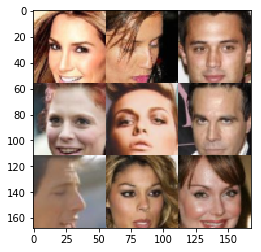

In [2]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np
import math

# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_dir=r'C:\Users\liori\datasets'
data_files = glob(os.path.join(data_dir, 'celebA/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5

def images_square_grid(images, mode='RGB'):
    """
    Helper function to save images as a square grid (visualization)
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im
        
test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
pyplot.imshow(images_square_grid(test_images))

In [3]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 32, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 64, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 128, 5, 2, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*128))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

In [4]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*128)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 128))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 32, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

In [5]:

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

In [6]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [7]:
def images_square_grid(images, mode='RGB'):
    """
    Helper function to save images as a square grid (visualization)
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(images_square_grid(samples))
    pyplot.show()

In [8]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])

Epoch 1/2... Discriminator Loss: 0.3284... Generator Loss: 6.5189


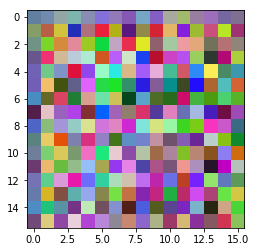

Epoch 1/2... Discriminator Loss: 0.3260... Generator Loss: 7.5209


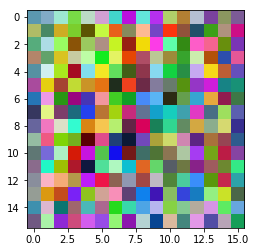

Epoch 1/2... Discriminator Loss: 0.3260... Generator Loss: 8.2829


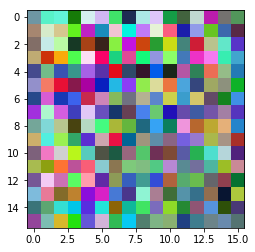

Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 8.7568


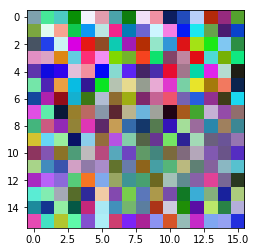

Epoch 1/2... Discriminator Loss: 0.3253... Generator Loss: 9.2091


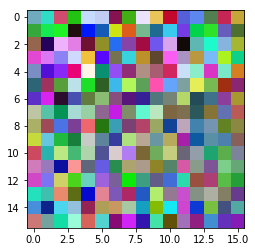

Epoch 1/2... Discriminator Loss: 0.3254... Generator Loss: 9.2482


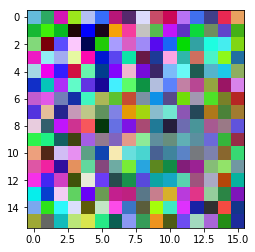

Epoch 1/2... Discriminator Loss: 0.3252... Generator Loss: 9.5826


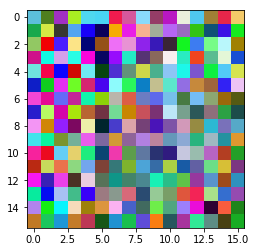

Epoch 1/2... Discriminator Loss: 0.3253... Generator Loss: 10.2826


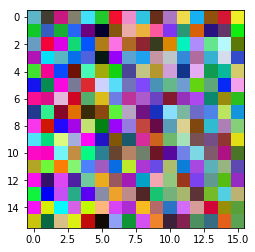

Epoch 1/2... Discriminator Loss: 0.3257... Generator Loss: 9.8221


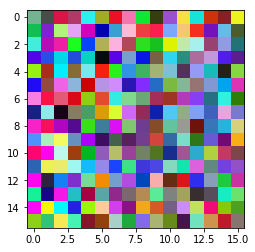

Epoch 1/2... Discriminator Loss: 0.3256... Generator Loss: 10.1844


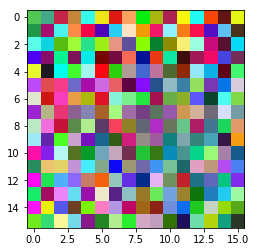

Epoch 1/2... Discriminator Loss: 0.3253... Generator Loss: 10.4049


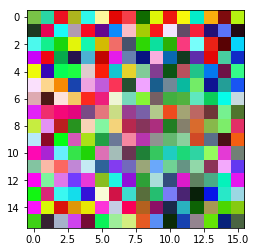

KeyboardInterrupt: 

In [9]:

batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)

AttributeError: 'tuple' object has no attribute 'ndims'